# Getting Started with Pyro

Okay!  So we've gotten our feet wet with torch, and actually feel pretty good.  It was quite easy to implement a very readable version of gradient descent, which I was quite happy with. 

With that groundwork, lets explore pyro!  Pyro was developed by Uber for Bayesian inference, and looks like a good candidate as a next step from pymc3.

As we're going through it's important to keep a few things in mind:

  *  This isn't our only option. We could still transition over to Tensorflow and Edward.
  *  We want readible models in the same way that pymc3 is very transparent about its models.  
  *  A model in pyro shouldn't be much longer that its corresponding version in pymc3.
  
And with that, lets get started  

In [79]:
import torch as t # I don't see the `as t` thing in other code, but I like it
from torch.autograd import Variable

import pyro
import pyro.distributions as dist

In [41]:
# Let create the unit normal!
mu = Variable(t.zeros(1))
sigma = Variable(t.ones(1))
# dist.normal returns a sample
X = dist.normal(mu, sigma)

In [47]:
# Here's our sample
print(X)

Variable containing:
 0.5176
[torch.FloatTensor of size 1]



In [48]:
# and it's corresponding log probability
-dist.normal.log_pdf(X, mu, sigma)

Variable containing:
 1.0529
[torch.FloatTensor of size 1]

In pyro it seems like we'll often be mroe likely to describe getting a sample in a different way.

In [49]:
# Sample with the pyro.sample function
Y = pyro.sample("unit_norm", dist.normal, mu, sigma)

Let's put this together into a model

In [56]:
def weather():
    """The weather generator function
    
    A stochastic function which returns a sample
    with either a cloudy or sunny classification
    and the temperature
    """
    # Cloud happens with probability 0.3
    cloudy = pyro.sample('cloudy', dist.bernoulli,
                         Variable(t.Tensor([0.3])))
    
    # If the value of the cloudy sample is 1, then cloudy
    # I love how this is done with python control flow
    if cloudy.data[0] == 1.0:
        cloudy = 'cloudy'
    else:
        cloudy = 'sunny'
        
    # Once we know the weather, sample the temperature
    # These provide our priors for cloud and sunny weather
    # The use of dictionaries is just some nice syntax that's
    # saving us from writing a longer if statement.
    mean_temp = {'cloudy': [55.], 'sunny': [75.]}[cloudy]
    sigma_temp = {'cloudy': [10.], 'sunny': [15.]}[cloudy]
    temp = pyro.sample('temp', dist.normal,
                       Variable(t.Tensor(mean_temp)),
                       Variable(t.Tensor(sigma_temp)))
    return cloudy, temp.data[0]

In [57]:
# Drawing some samples from our generator
for _ in range(3):
    print(weather())

('sunny', 50.01393127441406)
('sunny', 82.3631362915039)
('cloudy', 50.26835250854492)


In [60]:
# Building on an existing stochastic function is easy, since it's
# all just python
def go_to_the_beach():
    cloudy, temp = weather()
    if temp > 80.:
        p = 0.7
    elif temp < 80. and cloudy == 'sunny':
        p = 0.4
    else:
        p = 0.05
    
    decision = pyro.sample('decision', dist.bernoulli,
                           Variable(t.Tensor([p])))
    
    outcome = 'yes' if decision.data[0] == 1 else 'no'
    return cloudy, temp, outcome

In [65]:
for _ in range(3):
    print(go_to_the_beach())

('sunny', 88.06019592285156, 'yes')
('cloudy', 59.7537841796875, 'no')
('sunny', 65.88948822021484, 'yes')


Delightful!  Creating different random variables and then sampling from them is quite straightforward. Maybe even easier than pymc3.

So lets move on and get to some inference. 

Suppose we have a math assessment we give to kids (funny right), but it doesn't always give the best score representing a students ability.  To compensate we will add a 90% confidence interval based on our observations of the student. 

In [89]:
def math_assessment(low, high):
    # Compute the parameters of the distribution corresponding  
    # to my CI
    mu = Variable(t.Tensor([(low + high) / 2.]))
    sigma = Variable(t.Tensor([(high - low) / 3.29]))
    quantile = pyro.sample("quantile", dist.normal, mu, sigma)
    # Our CI serves as the mean for our measurement data
    # Note that this measurement is an observed variable, but we
    # haven't indicated that within the model quite yet.  We could
    # do so by adding the obs argument and providing the observed
    # 
    return pyro.sample("measurement", dist.normal, quantile, Variable(t.Tensor([50.])))

In [116]:
for _ in range(3):
    print(math_assessment(150, 250))

Variable containing:
 180.4416
[torch.FloatTensor of size 1]

Variable containing:
 282.2289
[torch.FloatTensor of size 1]

Variable containing:
 160.2915
[torch.FloatTensor of size 1]



In [91]:
from pyro.infer import Marginal, Importance
# This class is an importance sampler which we'll use to draw
# from the posterior of math_assessment. It looks like we'll often
# just pass this class into Marginal. 
posterior = Importance(math_assessment, num_samples=100)

In [114]:
guess = (150, 250)
# We'll now define marginal.  Marginal acts exactly like math_assessment
# except 
marginal = Marginal(posterior)
print(marginal(*guess))

Variable containing:
 213.8728
[torch.FloatTensor of size 1]



Text(0,0.5,'#')

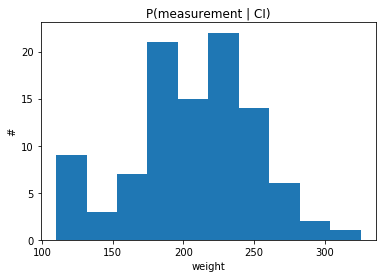

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([marginal(150, 250).data[0] for _ in range(100)])
plt.title("P(measurement | CI)")
plt.xlabel("weight")
plt.ylabel("#")

In [101]:
conditioned_test = pyro.condition(
    math_assessment, data = {"measurement": Variable(t.Tensor([140]))})